# Машинное обучение 2020, часть 2, семинар 8. Композиции алгоритмов

## Краткое напоминание про композиции

![](https://i.ibb.co/Wsf0s0m/bagging.jpg)

![](https://i.ibb.co/k16BL9v/boosting.jpg)

![](https://i.ibb.co/r5VPDd8/stacking.jpg)

## Стекинг на практике

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

### Датасет

Наш сегодняшний датасет - это датасет бросков в игре дартс:

In [ ]:
#!wget https://raw.githubusercontent.com/ben519/MLPB/master/Problems/Classify%20Dart%20Throwers/_Data/train.csv
train_df = pd.read_csv('train.csv')
train_df.head()

,ID,XCoord,YCoord,Competitor
0,111,0.943354,-0.184819,Bob
1,92,0.121557,-0.927656,Bob
2,20,0.818485,0.375437,Bob
3,75,0.867462,-0.159851,Sue
4,10,-0.817321,-0.373419,Kate


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


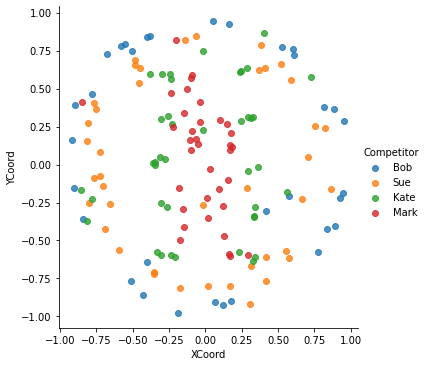

In [ ]:
sns.lmplot('XCoord', 'YCoord', data=train_df, hue='Competitor', fit_reg=False)
plt.show()

In [ ]:
#!wget https://raw.githubusercontent.com/ben519/MLPB/master/Problems/Classify%20Dart%20Throwers/_Data/test.csv
test_df = pd.read_csv('test.csv')
test_df.head()

,ID,XCoord,YCoord,Competitor
0,6,0.064729,0.356983,Mark
1,12,-0.766731,-0.255876,Sue
2,22,0.182282,-0.540976,Mark
3,34,-0.908910,0.223945,Bob
4,47,0.992230,-0.085550,Bob


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


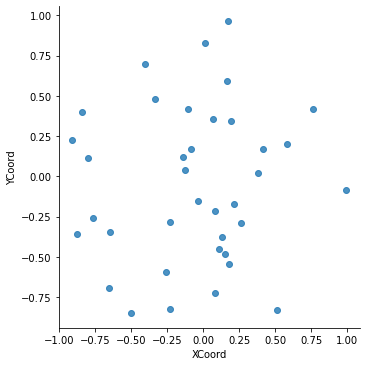

In [ ]:
sns.lmplot('XCoord', 'YCoord', data=test_df, fit_reg=False)
plt.show()

Подготовим обучающую выборку в более привычном виде, а также подготовимся к визуализации разделяющей гиперплоскости:

In [ ]:
X, y = train_df.values[:, 1:-1], train_df.values[:, -1:]

In [ ]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

In [ ]:
y_temp = []
for name in y:
    if name == 'Bob':
        y_temp.append(1)
    elif name == 'Mark':
        y_temp.append(2)
    elif name == 'Sue':
        y_temp.append(3)
    elif name == 'Kate':
        y_temp.append(4)
y = np.array(y_temp)

### Одиночные алгоритмы

Наш первый подопытный - kNN:

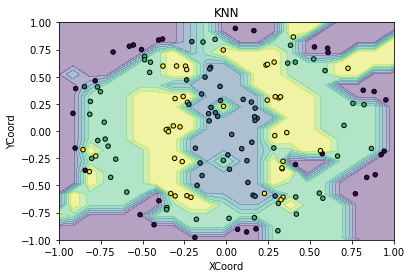

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X, y)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.title('KNN')
plt.xlabel('XCoord')
plt.ylabel('YCoord')
plt.show()

А второй - SVM:

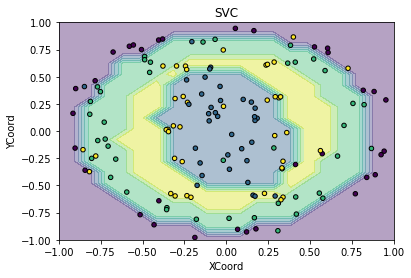

In [ ]:
from sklearn.svm import SVC

clf = SVC(kernel='poly', degree=2)
clf.fit(X, y)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.title('SVC')
plt.xlabel('XCoord')
plt.ylabel('YCoord')
plt.show()

Когда у нас есть два базовых классификатора (каждый из которых, как видно, справляется с классификацией очень по-разному), можно попытаться выжать из их комбинации всё :)

### Рецепт хорошего стекинга

Самый лучший рецепт - это выполненный своими руками! ;) Поэтому, слушайте внимательно:

**Задание 1 (1 балл)**.
* Подберите оптимальные параметры для двух базовых классификаторов. Посчитайте для них accuracy.
* Разбейте train на 5 фолдов.
* Для каждого фолда из train обучите классификатор на остальных и в качестве мета-фичи объектов этого фолда запишите предсказания моделей
* Обучите модель на всём train и для каждого объекта из test вычислите мета-фичи
* Возьмите новый классификатор и обучите его на train с мета-фичами
* Предскажите метки на test и измерьте accuracy

Бонус: у кого с помощью стекинга этих двух моделей получится наилучший результат на test, получит дополнительные 0.5 балла :)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 10)}
knn_cv = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
knn_cv.fit(X, y)

print(knn_cv.best_params_, knn_cv.best_score_)
best_param_knn = knn_cv.best_params_

{'n_neighbors': 1} 0.6533333333333333


In [ ]:
param_grid = [
  {'C': [1, 10, 100, 500, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 500, 1000], 'gamma': [0.1, 0.001, 0.001, 0.0001, 0.00001], 'kernel': ['rbf']},
  {'C': [1, 10, 100, 500, 1000], 'degree': [2, 3, 4, 5], 'kernel': ['poly']}
 ]

svm = SVC()
svm_cv = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
svm_cv.fit(X, y)

print(svm_cv.best_params_, svm_cv.best_score_)
best_param_svm = svm_cv.best_params_

{'C': 10, 'degree': 2, 'kernel': 'poly'} 0.8066666666666666


In [ ]:
from sklearn.model_selection import KFold

train_df['knn_meta'] = np.zeros(len(X)).astype(int)
train_df['svm_meta'] = np.zeros(len(X)).astype(int)

kf = KFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in kf.split(X):
  # print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  knn = KNeighborsClassifier(**best_param_knn)
  knn.fit(X_train, y_train)
  train_df['knn_meta'].iloc[test_index] = knn.predict(X_test)

  svm = SVC(**best_param_svm)
  svm.fit(X_train, y_train)
  train_df['svm_meta'].iloc[test_index] = svm.predict(X_test)

In [ ]:
X_test, y_test = test_df.values[:, 1:-1], test_df.values[:, -1:]

y_temp = []
for name in y_test:
    if name == 'Bob':
        y_temp.append(1)
    elif name == 'Mark':
        y_temp.append(2)
    elif name == 'Sue':
        y_temp.append(3)
    elif name == 'Kate':
        y_temp.append(4)
y_test = np.array(y_temp)

X_test.shape, y_test.shape

((37, 2), (37,))

In [ ]:
knn = KNeighborsClassifier(**best_param_knn)
knn.fit(X, y)
test_df['knn_meta'] = knn.predict(X_test)

svm = SVC(**best_param_svm)
svm.fit(X, y)
test_df['svm_meta'] = svm.predict(X_test)

In [ ]:
train_df.drop(['Competitor'], inplace=True, axis=1)
test_df.drop(['Competitor'], inplace=True, axis=1)

train_df.head(), test_df.head()

(    ID    XCoord    YCoord  knn_meta  svm_meta
 0  111  0.943354 -0.184819         3         1
 1   92  0.121557 -0.927656         1         1
 2   20  0.818485  0.375437         3         3
 3   75  0.867462 -0.159851         1         3
 4   10 -0.817321 -0.373419         1         1,
    ID    XCoord    YCoord  knn_meta  svm_meta
 0   6  0.064729  0.356983         2         2
 1  12 -0.766731 -0.255876         4         3
 2  22  0.182282 -0.540976         2         2
 3  34 -0.908910  0.223945         1         1
 4  47  0.992230 -0.085550         1         1)

In [ ]:
X_train = pd.get_dummies(train_df, columns=['knn_meta', 'svm_meta'], drop_first=True).values[:, 1:]
X_train.shape

(150, 8)

In [ ]:
X_test = pd.get_dummies(test_df, columns=['knn_meta', 'svm_meta'], drop_first=True).values[:, 1:]
X_test.shape

(37, 8)

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y)
y_pred = clf.predict(X_test)

print(f'{accuracy_score(y_test, y_pred):.5f}')

0.83784


Вопросы на засыпку:
* почему мета-фичи для объектов из train нужно получать так странно? Почему бы не обучиться на всём train и не сделать после этого предсказания?
* как правильно делать кросс-валидацию? Нормально ли использовать те же фолды, что и при обучении мета-фичей или нет?

## Градиентный бустинг

![](https://miro.medium.com/max/1024/0*6iP5_GhicmoijUu-.png)

### Краткое напоминание

Основано на [замечательном цикле статей](https://explained.ai/gradient-boosting/index.html)

#### Аддативное моделирование

Предположим, у нас есть некоторая неизвестная зависимость:

![](https://explained.ai/gradient-boosting/images/L2-loss/L2-loss_additive_2.svg)

Предположим, что она состоит из суммы нескольких более простых функций. Как бы нам их отгадать?

Раз при $x=0$ получается, что $y=30$, в качестве первой функции возьмём $f(x)=30$.

Также мы видим, что у нас наша зависимость наклонена относительно оси $Ox$, поэтому неплохая догадка - это функция $f(x)=y$

А при виде волнистости мы обычно вспоминаем $f(x)=\sin x$

В итоге если сложить всё вместе, то получится исходная функция. Как удачно!

![](https://explained.ai/gradient-boosting/images/L2-loss/L2-loss_additive_3.svg)

То есть мы приблизили неизвестную нам функцию с помощью суммы других, более простых, функций, т.е.
$$
F(x) = \sum\limits_{i=0}^mf_m(x)
$$

А в машинном обучении мы как раз по данным и хотим неизвестную функцию зависимости восстановить. Градиентный бустинг делает это как раз с помощью аддитивного моделирования.

#### Бустинг

Бустинг -- это когда мы на каждом шаге выбираем алгоритм $f_m(x)$, который лучше всего подходит под ошибки построенной к данному моменту композиции:
$$
F_m(x) = F_{m-1}(x) + \Delta_m(x)
$$

![](https://explained.ai/gradient-boosting/images/golf-dir-vector.png)

#### Градиентный бустинг

Давайте предположим, что нам нужно оптимизировать RMSE:
$$
L(y, F_M(x))=\frac{1}{N}\sum\limits_{i=0}^n(y_i-F_M(x_i))^2
$$

Подобрать нужно оптимальную $F_M$, для которой неизвестен её общий вид (а то мы могли бы явно продифференцировать по параметрам)

Раз не удаётся это сделать по параметрам, давайте продифференцируем по ответам $\hat y_j=F_m(x_j)$:
$$
\frac{\partial L}{\partial \hat y_j}= -2(y_j - \hat y_j)
$$

То есть в итоге
$$
\nabla_{\hat y} L(y, \hat y) = -2(y - \hat y)
$$

Если теперь мы будем рассматривать шаг градиентного спуска, то увидим, что нам нужно прибавлять нечто, похожее на $y - \hat y$. А ровно это мы и делаем, придумывая на каждом шаге алгоритм $\Delta_m$, который должен больше всего походить на текущие ошибки.

### Основные фреймворки

Три основных фреймворка для градиентного бустинга:
* https://github.com/dmlc/xgboost
* https://github.com/microsoft/LightGBM
* https://github.com/catboost/catboost

In [ ]:
!pip3 install catboost

In [ ]:
import xgboost
import lightgbm
import catboost

Загрузим датасет с ценами на квартиры в Бостоне:

In [170]:
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, mean_squared_error


rng = np.random.RandomState(31337)

boston = load_boston()
y = boston['target']
X = boston['data']

kf = KFold(n_splits=5, shuffle=True, random_state=rng)

In [171]:
import xgboost as xgb
from xgboost import XGBRegressor, DMatrix
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

Для простейшего применения интерфейс крайне похож на регрессоры из sklearn (всё те же fit-predict).

Сравним между собой все три вида бустинга и линейную модель:

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
for fold_index, (train_index, test_index) in enumerate(kf.split(y)):
  lin_model = LinearRegression().fit(X[train_index], y[train_index])
  xgb_model = XGBRegressor(objective ='reg:squarederror').fit(X[train_index], y[train_index])
  lgbm_model = LGBMRegressor().fit(X[train_index], y[train_index])
  cb_model = CatBoostRegressor(silent=True).fit(X[train_index], y[train_index])
  
  lin_predictions = lin_model.predict(X[test_index])
  xgb_predictions = xgb_model.predict(X[test_index])
  lgbm_predictions = lgbm_model.predict(X[test_index])    
  cb_predictions = cb_model.predict(X[test_index])
  
  actuals = y[test_index]
  print ("RMSE on fold {}: Linear: {:.5f}, XGBoost: {:.5f}, LGBM: {:.5f}, CatBoost: {:.5f}".format(
      fold_index,
      np.sqrt(mean_squared_error(actuals, lin_predictions)),
      np.sqrt(mean_squared_error(actuals, xgb_predictions)),
      np.sqrt(mean_squared_error(actuals, lgbm_predictions)),        
      np.sqrt(mean_squared_error(actuals, cb_predictions))))

RMSE on fold 0: Linear: 5.77960, XGBoost: 4.81539, LGBM: 5.06492, CatBoost: 4.28196
RMSE on fold 1: Linear: 4.73472, XGBoost: 2.64409, LGBM: 2.55923, CatBoost: 2.55070
RMSE on fold 2: Linear: 4.30159, XGBoost: 3.49083, LGBM: 3.73316, CatBoost: 3.19339
RMSE on fold 3: Linear: 4.63398, XGBoost: 2.75256, LGBM: 2.96340, CatBoost: 2.51026
RMSE on fold 4: Linear: 4.69841, XGBoost: 3.01303, LGBM: 2.79578, CatBoost: 2.82932


**Задание 2 (0.5 балла)**. А нет, линейную модель к сравнению добавите вы!

Добавила в твой код. Бусты пробили бейзлайн :)

Сегодня мы будем сравнивать два из этих трёх популярных фреймворка: XGBoost и CatBoost

### Хранение данных

#### XGBoost

Для хранения данных используется класс *xgboost.DMatrix*. Он хранит в себе:
  - **data**. Матрица объект-признак;
  - **label**. Вектор с таргетом (для обучения и валидации);
  - **weight**. Вектор весов объектов;
  - **feature_names**. Названия факторов.
  
Функция **xgboost.train()** обучает модель. Принимает на вход DMatrix, словарь с гиперпараметрами модели и еще всякие опции для обучения через аргументы. 

*Количество деревьев (num_boost_round)* указывается явно в аргументах train, а не в словаре параметров.
 
Возвращает бустер (**xgboost.booster**). У бустера есть метод **predict**, который делает предсказания.

[Подробнее](https://xgboost.readthedocs.io/en/latest/python/python_api.html)

**Задание 3. (0.5 балла)** Нарисуйте график зависимости средней ошибки на кросс-валидации от количества деревьев.

In [ ]:
params = {
    "objective": "reg:squarederror",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "max_depth": 6,
    "tree_method": "hist"
}

for fold_index, (train_index, test_index) in enumerate(kf.split(y)):    
    xgtrain = DMatrix(X[train_index], label=y[train_index])
    xgtest = DMatrix(X[test_index], label=y[test_index])

    bst = xgb.train(params, xgtrain, num_boost_round=20)

    print ("RMSE on fold {}: {}".format(fold_index, bst.eval(xgtest)))

RMSE on fold 0: [0]	eval-rmse:2.339549
RMSE on fold 1: [0]	eval-rmse:2.841919
RMSE on fold 2: [0]	eval-rmse:3.468769
RMSE on fold 3: [0]	eval-rmse:3.714972
RMSE on fold 4: [0]	eval-rmse:2.991589


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
scores = []

for n_trees in range(1, 100, 5):
  cv_scores = []
  for fold_index, (train_index, test_index) in enumerate(kf.split(y)):    
    xgtrain = DMatrix(X[train_index], label=y[train_index])
    xgtest = DMatrix(X[test_index], label=y[test_index])

    bst = xgb.train(params, xgtrain, num_boost_round=n_trees)
    y_pred = bst.predict(xgtest)
    rmse = np.sqrt(mean_squared_error(y[test_index], y_pred))

    cv_scores.append(rmse)
    # print ("RMSE on fold {}: {}".format(fold_index, bst.eval(xgtest)))
  
  scores.append(np.mean(cv_scores))

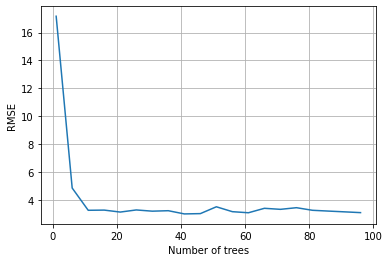

In [ ]:
plt.plot(range(1, 100, 5), scores)
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.grid()
plt.show()

#### CatBoost

Аналогом для класса DMatrix в катбусте служит класс **catboost.Pool**. Помимо прочего, содержит индексы категориальных факторов и описание пар для режима попарного обучения.

[Подробнее](https://catboost.ai/docs/concepts/python-reference_pool.html)

**Задание 4. (0.5 балла)** Проделайте аналогичную работу используя CatBoost.

In [ ]:
from catboost import Pool

In [ ]:
scores = []

for n_trees in range(1, 100, 5):
  cv_scores = []
  for fold_index, (train_index, test_index) in enumerate(kf.split(y)):  
    train_data = Pool(data=X[train_index], label=y[train_index])
    test_data =  Pool(data=X[test_index], label=y[test_index])

    model = CatBoostRegressor(num_trees=n_trees)
    model.fit(train_data)
    y_pred = model.predict(test_data)

    rmse = np.sqrt(mean_squared_error(y[test_index], y_pred))

    cv_scores.append(rmse)
  scores.append(np.mean(cv_scores))

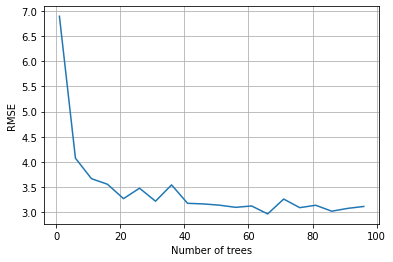

In [ ]:
plt.plot(range(1, 100, 5), scores)
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.grid()
plt.show()

###  Параллелизм

* По факторам;
* Есть возможность запускаться параллельно на CPU или на GPU

### Функции потерь и метрики качества

В обоих библиотеках встроено множество различных функций потерь.

XGBoost:

* reg:linear

* reg:logistic

* binary:logistic

* binary:logitraw

* multi:softmax

* rank:pairwise

* ...

[Метрики и функции потерь](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters)

CatBoost:
* RMSE

* LogLoss

* CrossEntropy

* MultiClass

* PairLogit

* PairLogitPairwise

* QueryRMSE

* ...

[Метрики и функции потерь](https://catboost.ai/docs/concepts/loss-functions.html#loss-functions__regression)

Метрики используются для ранней остановки обучения - обучение завершается, если значение метрики перестало улучшаться. 

В обеих моделях имеется возможность реализовать свои метрики и функции потерь.

### Визуализация

#### CatBoost

В CatBoost можно строить крирвые обучения "из коробки":

In [172]:
from sklearn.model_selection import train_test_split

X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.25)
X_validate, X_test, y_validate, y_test = train_test_split(X_rest, y_rest, test_size=0.5)

In [ ]:
cb = CatBoostRegressor(silent=True, eval_metric="MAE", custom_metric=["MAPE"])

In [ ]:
cb.fit(X_train, y_train, eval_set=[(X_validate, y_validate), 
                                   (X_test, y_test)],
       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Построение деревьев

![text](https://qph.fs.quoracdn.net/main-qimg-5274e48e1766230e22e3cdd7e83019ce.webp)

#### XGBoost

По умолчанию деревья строятся слой за слоем (grow_policy="depthwise"). После достижения максимальной глубины (max_depth) происходит pruning - обрезание листьев, которые не дают прироста в качесте (отрицательный Gain).

При выборе grow_policy="lossguide" будет выбираться вершина и сплит для нее, которые максимально уменьшают функцию потерь. Это воспроизводит поведение в библиотеке lightGBM. В результате могут получиться перекошенные деревья (см. левый рисунок выше).

#### CatBoost

Деревья также строятся по *слоям*. При этом используются *oblivious decision trees*, то есть на каждом уровне дерева выбирается общий предикат для всех вершин.

Сплит выбирается из соображений наилучшего приближения вектора градиента.

### Бинаризация

Использовать все возможные значения каждого фактора для выбора сплита - очень накладно. Поэтому обычно значения фактора разбиваются на небольшое число корзин (бины). Существуют разные стратегии выбора бинов.

#### XGBoost

Задается параметром *tree_method*. Возможные значения:
  - **exact**. Используются всевозможные значения факторов;
  - **approx**. На каждой итерации бины пересчитываются (хитрым способом, в зависимости от значений градиента). Более того, можно пересчитывать локально для каждой вершины строящегося дерева. Параметр *sketch_eps* задает примерное кол-во бинов (число бинов ~ 1/sketch_eps);
  - **hist**. Гистограмма, которая считается один раз перед обучением - работает гораздо быстрее (8x-10x) без особой потери качества.

In [ ]:
xgtrain = xgb.DMatrix(X_train, label=y_train)
xgvalidate = xgb.DMatrix(X_validate, label=y_validate)
xgtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
for tree_method in ["exact", "approx", "hist"]:
    params = {
        "tree_method": tree_method,
        "sketch_eps": 0.2,
        "silent": True
    }
    bst = xgb.train(params, xgtrain, num_boost_round=100,)
    print ("binarization: {}\t, score: {}".format(tree_method, bst.eval(xgvalidate)))

binarization: exact	, score: [0]	eval-rmse:2.355986
binarization: approx	, score: [0]	eval-rmse:2.687735
binarization: hist	, score: [0]	eval-rmse:2.320263


#### CatBoost

 Выбрать стратегию бинаризации можно установив параметр *feature_border_type*.
 
  - **Uniform**. Границы выбираются равномерно по значениям;
  - **Median**. В каждый бин попадает примерно одинаковое число различных значений;
  - **UniformAndQuantiles**. Uniform + Median;
  - **MaxLogSum, GreedyLogSum**. Максимизируется значение формулы $\sum_{i=1}^K \log(n_i)$, где $K$ - требуемое кол-во бинов, $n_i$ число объектов в этом бакете;
  - **MinEntropy**. Аналогично, но максимизируется энтропия: $-\sum_{i=1}^K n_i \log(n_i)$

**Задача 5. (0.5 балла)** Для каждого варианта стратегии бинаризации выведите MSE, который получается :)

In [ ]:
for bin_strategy in ['Uniform', 'Median', 'UniformAndQuantiles', 'MaxLogSum', 'MinEntropy']:
  model = CatBoostRegressor(feature_border_type=bin_strategy, silent=True)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  
  print ("binarization: {}\t, score: {}".format(bin_strategy, rmse))

binarization: Uniform	, score: 2.539933893500852
binarization: Median	, score: 2.5105035990515834
binarization: UniformAndQuantiles	, score: 2.3854718088775138
binarization: MaxLogSum	, score: 2.499149403948872
binarization: MinEntropy	, score: 2.4771219418866757


### Пропущенные значения

#### XGBoost

  * Есть возможность явно заменять пропущенные значения на фиксированное число (параметр *missing* при создании *DMatrix*).

#### CatBoost

За политику обработки пропущенных значений отвечает параметр *nan_mode*. Возможные значения:
  * **Min/Max** - пропуски отправляются либо всегда в левую ветку, либо всегда в правую;
  * **Forbidden** - заметив NaN, модель начинает неистово истерить, брызжа исключениями во все стороны.

### Важности фичей

#### XGBoost

In [175]:
from collections import Counter
params = {
    "objective": "reg:linear",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "max_depth": 6,
    "tree_method": "hist",
    "silent": True
}

bst = xgb.train(params, DMatrix(X_train, y_train, feature_names=boston['feature_names']), num_boost_round=100)

fstrs = bst.get_fscore()

for name, value in Counter(bst.get_fscore()).most_common():
    print ("{}\t{}".format(name, value))

CRIM	658
RM	465
AGE	317
DIS	302
LSTAT	298
B	279
NOX	212
INDUS	89
TAX	84
PTRATIO	72
ZN	57
RAD	47
CHAS	16


In [ ]:
xgb.plot_importance(bst)

#### CatBoost

**Задание 6. (0.5 балла)** И, традиционно, проделайте аналогичную работу над CatBoost'ом :)

In [173]:
model = CatBoostRegressor(feature_border_type=bin_strategy, silent=True)
model.fit(X_train, y_train)
features = model.get_feature_importance()
model.feature_names_

In [179]:
idx = np.argsort(features)[::-1]
for name, imp in zip(np.array(model.feature_names_)[idx], np.array(features)[idx]):
  print(name, imp)

12 31.5001177069685
5 25.96495945699906
7 9.649085633360153
4 6.174637640357222
0 5.106309000445724
6 4.407339052247471
10 4.103203249923547
11 3.3891562942973574
9 3.1374699265044046
2 2.5805541888133687
8 1.8285348916217816
1 1.0866693391929128
3 1.0719636192685142
